# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## July 13 2021

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.15.5 and additionally relies on Keras 2.2.4

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [2]:
%run ../src/layers/zoneout.py
%run ../src/layers/adabound.py
%run ../src/layers/convgru.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/layers/stochastic_weight_averaging.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py
%run ../src/models/metrics.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.8
DROPBLOCK_MAXSIZE = 4
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.03
L2_REG = 5e-4
MAX_DROPBLOCK = 0.95
FRESH_START = True
START_EPOCH = 1
END_EPOCH = 100
LEARNING_RATE = 1e-3

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [4]:
def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    #cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    #x = Add(name=prefix + "_csse_mul")([cse, sse])
    return sse


class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [5]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {0.1}")
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        print(inp.shape)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        print(f"Zoneout: {ZONE_OUT_PROB}")
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"Down block output shape {gru.shape}")
    return gru, steps

### Conv blocks

In [6]:
def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "SAME"):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    bn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
    print(f"{scope} {kernel_size} Conv 2D {bn_flag} {activation_flag} {csse_flag} {bias_flag} {drop_flag}")
    
    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if activation:
        conv = tf.nn.swish(conv)
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 8)
    if csse:
        conv = csse_block(conv, "csse_" + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size= block_size)
            conv = drop_block(conv, is_training)
    return conv

# Model definition

## Placeholders

In [7]:
n_bands = 17
reg = tf.contrib.layers.l2_regularizer(0.)
inp = tf.placeholder(tf.float32, shape=(None, 13, 28, 28, n_bands))
length = tf.placeholder_with_default(np.full((1,), 12), shape = (None,))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())

INFO:tensorflow:Scale of 0 disables regularizer.


## Layers

## Model

The model uses a UNet architecture where the encoder extracts increasingly abstract features and the decoder upsamples the features to the target resolution.

The encoder consists of three blocks:

- GRU: A bidirectional convolutional GRU with channel squeeze and spatial excitation, and group normalization, extracts 3x3 features from the multitemporal imagery
- Conv1: A MaxPool-conv-swish-groupNorm-sse layer takes the output of the GRU (size 28) and reduces to size 12
- Conv2: The output of the MaxPool-conv-swish-csse-DropBlock is a 4x4x128 encoded feature map

The decoder consists of two blocks:

- Upconv1: upsample-conv-swish-csse-concat-conv-swish
- Upconv2: upsample-conv-swish-csse-concat-conv-swish
- Output sigmoid


In [8]:
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2

gru_input = inp[:, :12, ...]
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [28, 28],
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_input = ReflectionPadding2D((1, 1,))(median_input)
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)
print(f"Median conv: {median_conv.shape}")

concat = tf.concat([gru, median_conv], axis = -1)
concat = ReflectionPadding2D((1, 1,))(concat)
concat = conv_swish_gn(inp = concat, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "VALID")
print(f"Concat: {concat.shape}")

# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID")
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)

up2 = tf.concat([up2, conv1_crop], -1)
up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, padding = "VALID")

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
gru_crop = Cropping2D(6)(concat)
up3 = tf.concat([up3, gru_crop], -1)

up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID")

init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(up3) # For focal loss
print(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")

GRU input shape (?, 12, 28, 28, 17), zoneout: 0.1
(?, 12, 28, 28, 17)

(3, 3, 33, 32)
(3, 3, 33, 32)
Zoneout: 0.8
Down block output shape (?, 28, 28, 32)


ZERO PADDING
conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Median conv: (?, 28, 28, 32)
ZERO PADDING
conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Concat: (?, 28, 28, 32)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Conv1: (?, 12, 12, 64)
conv2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
Encoded (?, 4, 4, 128)
ZERO PADDING
up2 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
ZERO PADDING
up2_out 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
ZERO PADDING
up3 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
out 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
The output is (?, 8, 8, 64), with a receptive field of 1
The output, sigmoid is (?, 14, 14, 1), with a receptive field of 1


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(f"This model has {total_parameters} parameters")

This model has 329929 parameters


In [10]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = LABEL_SMOOTHING):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return loss


def calc_dist_map(seg):
    """
    Utility function for calc_dist_map_batch that calculates the loss
    importance per pixel based on the surface distance function
    
     Parameters:
       seg (arr):
  
     Returns:
       res (arr):
    """
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            # If > 1 px, double the weight of the positive
            # If == 1 px, half the weight of the negative
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.5
                    ones[x + 1, y] = 0.5
                    ones[x, y + 1] = 0.5
                    ones[x, y - 1] = 0.5
                    ones[x - 1, y + 1] = 0.5
                    ones[x + 1, y + 1] = 0.5
                    ones[x + 1, y - 1] = 0.5
                    ones[x -1, y - 1] = 0.5

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    return loss


def bce_surface(y_true, y_pred, alpha, weight, beta):
    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)

    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(y_true, y_pred)
    surface = tf.reduce_mean(surface)
    
    bce = tf.reduce_mean(bce)
    bce = (1 - alpha) * bce
    surface_portion = alpha * surface

    result = bce + surface_portion
    return result

In [11]:

%run ../src/layers/adabound.py
def grad_norm(gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm
    

optimizer = AdaBoundOptimizer(1e-3, ft_lr)
train_loss = bce_surface(tf.reshape(labels, (-1, 14, 14, 1)), 
                         fm, weight = loss_weight, 
                         alpha = alpha, beta = beta_)
l2_loss = tf.losses.get_regularization_loss()
if len(tf.losses.get_regularization_losses()) > 0:
    print("Adding L2 loss")
    train_loss = train_loss + l2_loss

test_loss = bce_surface(tf.reshape(labels, (-1, 14, 14, 1)),
                        fm, weight = loss_weight, 
                        alpha = alpha, beta = beta_)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(train_loss)   

trainable_params = tf.trainable_variables()
gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
gradient_norm = grad_norm(gradients)
scale = 0.05 / (gradient_norm + 1e-12)
e_ws = []
for (grad, param) in gradients:
    e_w = grad * scale
    param.assign_add(e_w)
    e_ws.append(e_w)

sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
for (param, e_w) in zip(trainable_params, e_ws):
    param.assign_sub(e_w)
train_step = optimizer.apply_gradients(sam_gradients)


init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)

In [12]:
model_path  = "../models/small-temporal/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

path = model_path
saver.restore(sess, tf.train.latest_checkpoint(path))

Starting anew
INFO:tensorflow:Restoring parameters from ../models/small-temporal/model


In [13]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        
        
# SWA BLOCKS
model_vars = tf.trainable_variables()
swa = StochasticWeightAveraging()
swa_op = swa.apply(var_list=model_vars)
with tf.variable_scope('BackupVariables'):
    # force tensorflow to keep theese new variables on the CPU ! 
    backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
                                   initializer=var.initialized_value())
                   for var in model_vars]

swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in model_vars))
save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(model_vars, backup_vars)))
restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(model_vars, backup_vars)))

initialize_uninitialized(sess)

# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate indices
*  Stack X, Y, length data
*  Apply median filter to DEM

In [76]:
import hickle as hkl
normalize = False
train_x = hkl.load("../data/train/train_x.hkl")
train_y = hkl.load("../data/train/train_y.hkl")
data = pd.read_csv("../data/train/train_plot_ids.csv")

if not isinstance(train_x.flat[0], np.floating):
    assert np.max(train_x) > 1
    train_x = train_x / 65535.
    
train_x = np.delete(train_x, 11, -1)

In [77]:
def convert_to_db(x, min_db):
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x


def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator


def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis


def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis


def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis

In [78]:
train_x[..., -1] = convert_to_db(train_x[..., -1], 22)
train_x[..., -2] = convert_to_db(train_x[..., -2], 22)

indices = np.empty((train_x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(train_x)
indices[..., 1] = bi(train_x)
indices[..., 2] = msavi2(train_x)
indices[..., 3] = grndvi(train_x)

train_x = np.concatenate([train_x, indices], axis = -1)
med = np.median(train_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
train_x = np.concatenate([train_x, med], axis = 1)
print(train_x.shape)

(219, 13, 28, 28, 17)



# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [79]:
below_1 = [i for i, val in enumerate(train_x[..., :10]) if np.min(val) < -2]
above_1 = [i for i, val in enumerate(train_x[..., :10]) if np.max(val) > 2]
min_vals = [np.min(val) for i, val in enumerate(train_x[..., :10]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(train_x[..., :10]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(train_x) if np.sum(np.isnan(val)) > 100]
oob_vals = [i for i, val in enumerate(train_x) if np.max(val[..., 0]) > 0.7]

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print(f"Removing {len(outliers)} outlying training data points")
print(sorted(outliers))
train_x = np.delete(train_x, outliers, 0)
train_y = np.delete(train_y, outliers, 0)
data = data.drop(outliers, 0)
data.reset_index(inplace = True, drop = True)

print(train_x.shape)
print(train_y.shape)

Removing 0 outlying training data points
[]
(219, 13, 28, 28, 17)
(219, 14, 14)


## Standardization

In [80]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101, -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]
max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434, 0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

In [81]:
for band in range(0, train_x.shape[-1]):
    #mins = np.percentile(train_x[:, ..., band], 0.1)
    #maxs = np.percentile(train_x[:, ..., band], 99.9)
    mins = min_all[band]
    maxs = max_all[band]
    train_x[..., band] = np.clip(train_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[..., band] - midrange) / (rng / 2)
    train_x[..., band] = standardized
    #min_all.append(mins)
    #max_all.append(maxs)

print(min_all)
print(max_all)

[0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101, -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]
[0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434, 0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]


In [82]:
outliers = [139368676, 135847238, 135546165, 136446416, 139379033, 137966730,
            139201842, 139146753, 135546165, 135680251, 135697756, 135703958, 135809793,
 135809874, 135809913, 135847238, 136089167, 136089205, 136434315,136434751, 136434792, 136434852, 136434903,
 136434908, 136446261, 136446353, 136446416, 136446451, 136752959, 137966730, 138872345,
 138872603, 138872689, 139025570, 139027591, 139027614, 139046306,
 139077793, 139077852, 139146753, 139160490,139669281,139929363,
 139161820, 139189356, 139189539, 136318389, 135807724, 135680967, 139207880,
 139189689, 139191633, 139201842, 139201886, 139341952, 139342073, 139365739, 139365903,
 139368676, 139379033, 139379276, 139419912, 139189774, 139669397, 139940209, 139745924, 139319271, 
 139940210, 139940211, 139940212, 139940213,139940214,139940215,139940216, 139940217,139940218,139940219,
 139940220, 139940221, 139940222, 139940223, 139940224,139940225, 139940226,139940227,139940228, 140474053,
           139046981, 139291824, 135698166, 139277262, 139686333, 138900959, 136446306, 140474089, 140474144,
           140751023, 140751031, 140751033, 140751032, 140751040, 140751039, 140751082,
140751089, 140751111, 140751124, 140751221, 140750979, 140751095, 140751154, 140751239, ]

outliers = data[data['plot_id'].isin(outliers)]
outliers = list(outliers.index)
print(outliers, len(outliers))
train_x = np.delete(train_x, outliers, 0)
train_y = np.delete(train_y, outliers, 0)
data = data.drop(outliers, 0)
data.reset_index(inplace = True, drop = True)

[] 0


## Load and process test data

In [21]:
import hickle as hkl
test_x = hkl.load("../data/test/test_x.hkl")
test_y = hkl.load("../data/test/test_y.hkl")
test_data = pd.read_csv("../data/test/test_plot_ids.csv")

test_x = np.delete(test_x, 11, -1)
print(test_x.shape)

if not isinstance(test_x.flat[0], np.floating):
    assert np.max(test_x) > 1
    test_x = test_x / 65535.
    
test_x[..., -1] = convert_to_db(test_x[..., -1], 22)
test_x[..., -2] = convert_to_db(test_x[..., -2], 22)

indices = np.empty((test_x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(test_x)
indices[..., 1] = bi(test_x)
indices[..., 2] = msavi2(test_x)
indices[..., 3] = grndvi(test_x)

test_x = np.concatenate([test_x, indices], axis = -1)
med = np.median(test_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
test_x = np.concatenate([test_x, med], axis = 1)

below_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.max(val) > 1.66]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))

print(f"There are {len(outliers)} outliers")
print([x for x in test_data['plot_id'].iloc[outliers]])

test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

(975, 12, 28, 28, 13)
There are 0 outliers
[]


In [22]:
outliers = [139190811, 139190836]
outliers = test_data[test_data['plot_id'].isin(outliers)]
outliers = list(outliers.index)
print(outliers, len(outliers))

print(f"Removing {len(outliers)} outlying testing data points")
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

[392, 399] 2
Removing 2 outlying testing data points
[392, 399]


In [23]:
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[..., band] = np.clip(test_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[..., band] - midrange) / (rng / 2)
    test_x[..., band] = standardized
print("Finished data scaling")

Finished data scaling


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [24]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(30, 100, 9)]
print(percents)
print(f"There are {len(np.argwhere(sums == 0))} zeros")

[107.0, 155.32999999999998, 166.56, 176.16, 183.02, 191.5, 196.0, 196.0]
There are 5 zeros


In [25]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

def equibatch(train_ids, p = percents):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):

         Returns:
          equibatches (list):
    '''
    percents = [9.0, 17.0, 27.0, 40.0, 63.0, 105.0, 158.0]
    # 0, 5, 10, 14, 20, 32, 55, 80
    print(len(train_ids))
    train_ids_cp = train_ids
    np.random.shuffle(train_ids_cp)
    ix = train_ids_cp
    print(len(ix))
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z <= percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z <= percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z <= percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z <= percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z <= percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z <= percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z <= percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    
    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]], ids60[cur_ids[4]], 
                    ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

batch = equibatch(train_ids)

48
48
[6, 1, 1, 3, 1, 1, 1, 8, 26]


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


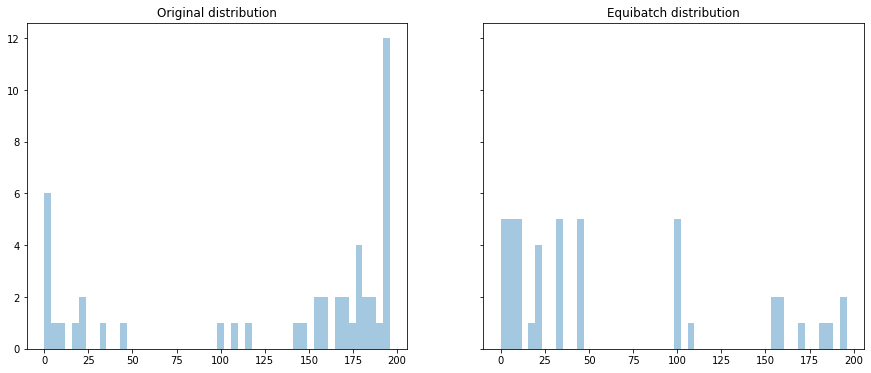

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(15, 6)
sns.distplot(np.sum(train_y, axis = (1, 2)), bins = 50, kde = False, ax = ax1)
ax1.set_title('Original distribution')
ax2.set_title('Equibatch distribution')
sns.distplot(np.sum(train_y[batch], axis = (1, 2)),
             bins = 50, kde = False, ax = ax2)

plt.show()

# Example equibatch

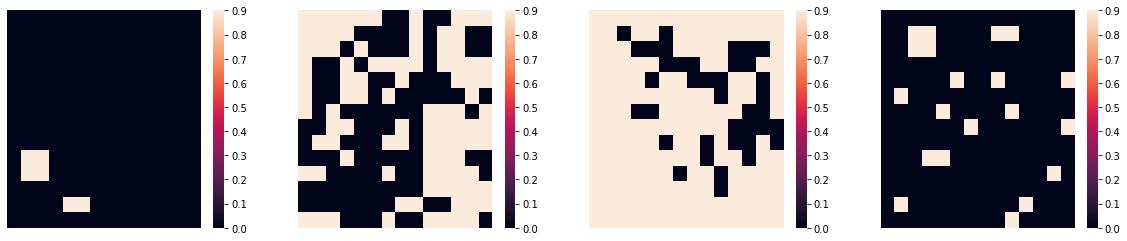

In [27]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

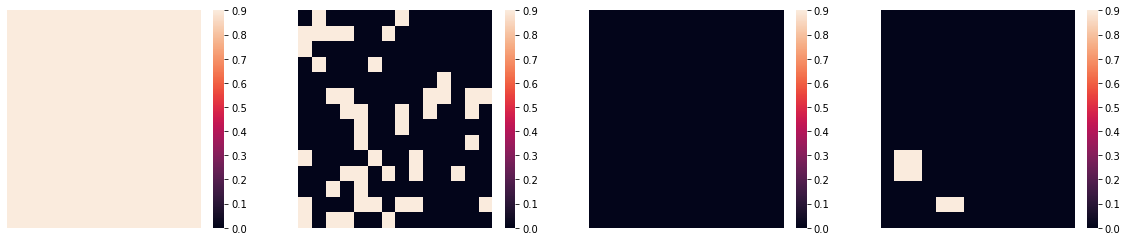

In [28]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])


# Loss definition


IndexError: index 85 is out of bounds for axis 0 with size 48

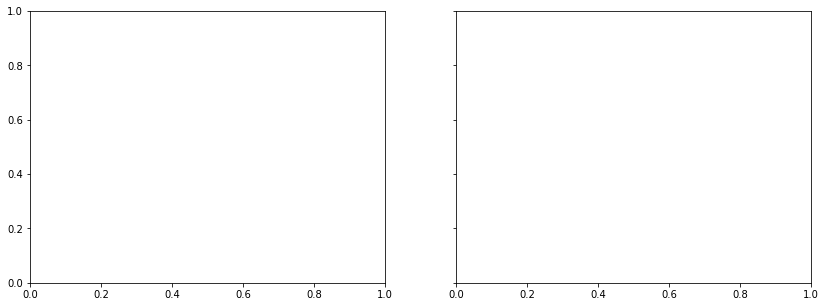

In [29]:
idx = 85 # 14
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(14, 5)
sns.heatmap(calc_dist_map(train_y[idx]), ax = ax1)
ax2.set_title('Ground truth Y')
ax1.set_title('Boundary loss mask')
sns.heatmap(train_y[idx], ax = ax2)
plt.show()

# Evaluation metrics

In [31]:
countries = {'all': [0, 1150]}

def dice_loss_tolerance(y_true, y_pred):
    numerator_data = np.zeros_like(y_true)
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[0], y+2])
            max_x = np.min([y_true.shape[0], x+2])
            if y_true[x, y] == 1:
                numerator_data[x, y] = np.max(y_pred[min_x:max_x, min_y:max_y])
                
    numerator = 2 * np.sum(y_true * numerator_data, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)
                    
            
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = 0
    stop_idx = len(test_x)
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    relaxed_f1 = 0
    preds = []
    vls = []
    trues = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197):
            x_input = test_x[test_sample].reshape(1, 13, 28, 28, n_bands)
            x_median_input = calc_median_input(x_input)
            y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                          #inp_median: x_median_input,
                                                          length: np.full((1,), 12),
                                                          is_training: False,
                                                          labels: test_y[test_sample].reshape(1, 14, 14),
                                                          loss_weight: 1.0,
                                                          alpha: 0.33,
                                                          })
            preds.append(y.reshape((14, 14)))
            vls.append(vl)
            trues.append(test_y[test_sample].reshape((14, 14)))
    dice_losses = []
    for thresh in range(7, 9):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
            if thresh == 8:
                if np.sum(true + pred) > 0:
                    dice_losses.append(0.5)
                   # dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
                else:
                    dice_losses.append(1.)
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        
        if f1_r > best_f1:
            haus = np.zeros((len(preds), ))
            for sample in range(len(preds)):
                pred = np.copy(preds[sample])
                pred[np.where(pred >= thresh*0.05)] = 1
                pred[np.where(pred < thresh*0.05)] = 0
                true = trues[sample]
                #dists = compute_surface_distances(np.array(true).reshape(14, 14, 1).astype(int),
                #                                  np.array(pred).reshape(14, 14, 1).astype(int),
                #                                  [1, 1, 1])
                #if np.sum(true + pred) > 0:
                #    haus_i = compute_robust_hausdorff(dists, 50)
                #    if not np.isinf(haus_i):
                #        haus[sample] = haus_i
                #if np.sum(true + pred) == 0:
                #    haus[sample] = 0.
                    
            dices = np.mean(dice_losses)
            haus = np.mean(haus)
            best_dice = 0.5
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05
            best_haus = 0.5
    print(f"{country}: Val loss: {np.around(np.mean(vls), 3)}"
          f" Thresh: {np.around(best_thresh, 2)}"
          f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
          f" D: {np.around(np.mean(best_dice), 3)} H: {np.around(best_haus, 3)}"
          f" Error: {np.around(error, 3)}")
    return np.mean(vls), best_f1, error, best_haus, np.mean(best_dice)

In [32]:
al = 0.33

def make_evaluation_csv(data):
    test_ids = [x for x in range(len(test_x))]
    print(len(test_ids))
    sums = []
    sum_preds = []
    trues = []
    preds = []
    for test_sample in test_ids:
        x_input = test_x[test_sample].reshape(1, 13, 28, 28, n_bands)
        #x_median_input = calc_median_input(x_input)
        y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                      #inp_median: x_median_input,
                                                      length: np.full((1,), 12),
                                                      is_training: False,
                                                      labels: test_y[test_sample].reshape(1, 14, 14),
                                                      loss_weight: 0.5,
                                                      alpha: al,
                                                      })
        preds.append(y.reshape((14, 14)))
        trues.append(test_y[test_sample].reshape((14, 14)))
    thresh = 0.3
    tps_relaxed = np.empty((len(preds), ))
    fps_relaxed = np.empty((len(preds), ))
    fns_relaxed = np.empty((len(preds), ))
    abs_error = np.empty((len(preds), ))
    
    tree_cover = []
    for sample in range(len(preds)):
        pred = np.copy(preds[sample])
        true = trues[sample]
        if thresh == 8:
            if np.sum(true + pred) > 0:
                dice_losses.append(0.5)
               # dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
            else:
                dice_losses.append(1.)
        pred[np.where(pred >= thresh)] = 1
        pred[np.where(pred < thresh)] = 0

        true_s = np.sum(true)
        pred_s = np.sum(pred)
        
        tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
        abs_error[sample] = int((true_s - pred_s) // 1.96)
        print(abs_error[sample])
        tps_relaxed[sample] = tp_relaxed
        fps_relaxed[sample] = fp_relaxed
        fns_relaxed[sample] = fn_relaxed       
        tree_cover.append(int( (np.sum(true) * 100) // 196))

    oa_error = np.mean(abs_error)
    precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
    recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
    f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
    data['error'] = abs_error
    data['tp'] = tps_relaxed
    data['fp'] = fps_relaxed
    data['fn'] = fns_relaxed
    data['tree_cover'] = tree_cover
    
    return data

# Graph set up

In [35]:
from sklearn.cluster import KMeans
x_med = np.median(train_x, axis = (1, 2, 3))
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_med)
clusters = kmeans.labels_

ModuleNotFoundError: No module named 'sklearn'

In [36]:
def fftIndgen(n):
    a = range(0, n//2+1)
    b = range(1, n//2)
    b = [x for x in b]
    b.reverse()
    a = [x for x in a]
   
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude).astype(np.float32)

def make_aug_masks(n, perc):
    masks = np.zeros((n, 24, 24))
    for i in range(n):
        gas = gaussian_random_field(Pk = lambda k: k**-5, size=24)
        percentile = np.clip(np.random.normal(perc, 0.1, 1), 0, 1)
        percentile = np.percentile(gas, percentile * 100)
        gas = gas <= percentile
        masks[i] = gas
    return masks


# Realistically rather than sampling from the entire dataset,
# We would want to match up each pair of samples such that they share the same
# principal components (?)

def cut_mix(x_batch, y_batch, ids, percent, batch_size, cluster = clusters):
    
    train_ids = [x for x in range(len(train_x))]
    cl_batch = clusters[ids]
    
    binary_mask = np.random.rand(batch_size)
    binary_mask = (binary_mask <= 0.25).astype(np.int)
    
    masks_x = make_aug_masks(batch_size, .33)
    masks_y = masks_x[:, 5:-5, 5:-5]
    masks_x = np.broadcast_to(
        masks_x[:, np.newaxis, :, :, np.newaxis], (batch_size, 13, 24, 24, 17))
    
    i = 0
    for x, y, cluster, mask in zip(x_batch, y_batch, cl_batch, binary_mask):
        if mask == 1:
            random_id = np.random.choice(clusters[clusters == cluster])
            x_random = train_x[random_id]
            y_random = train_y[random_id]

            x[masks_x[i] == 1] = x_random[masks_x[i] == 1]
            y[masks_y[i] == 1] = y_random[masks_y[i] == 1]
            i += 1

    return x_batch, y_batch

NameError: name 'clusters' is not defined

In [33]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids]
    #steps_to_noise = np.random.choice(np.arange(0, 12), 2, replace = False)
    #noise = np.random.normal(1, .025, size = (batch_size, 1, 24, 24, n_bands))
    #x[:, steps_to_noise, ...] = x[:, steps_to_noise, ...] * noise
    
    y = train_y[batch_ids]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    
    
    
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i] = x[i]
            y_batch[i] = y[i]
        if current_flip == 1:
            x_batch[i] = np.flip(x[i], 1)
            y_batch[i] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i] = np.flip(x[i], [2, 1])
            y_batch[i] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i] = np.flip(x[i], 2)
            y_batch[i] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    #x_batch, y_batch = cut_mix(x_batch, y_batch, batch_ids, 0.5, batch_size)
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([x for x in range(32)], 32)

In [34]:
def calc_median_input(x_batch):
    x_median = np.percentile(x_batch, 25, axis = (1))
    return x_median

x_batch_med = calc_median_input(x_batch_test)

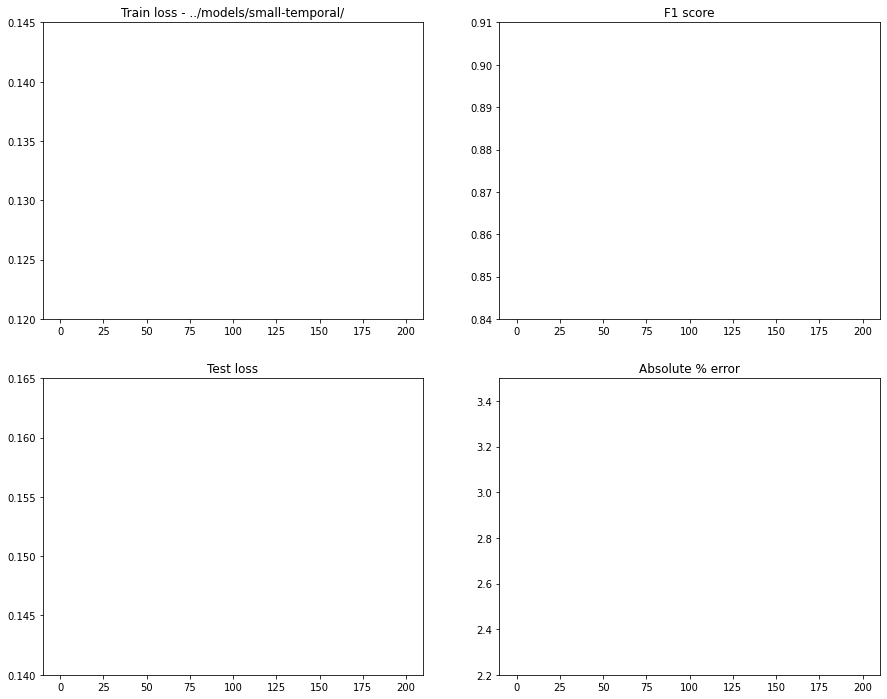

In [27]:
start = 0
end = 201
f, ((c1r1, c1r2), (c2r1, c2r2)) = plt.subplots(2, 2, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title(f"Train loss - {model_path}")
l1 = sns.scatterplot(y = metrics[0, start:end], x = np.arange(start, end), ax = c1r1)
l1.set(ylim=(0.120, .145))

c1r2.set_title("F1 score")
f =sns.scatterplot(y = metrics[5, start:end], x = np.arange(start, end), ax = c1r2)
f.set(ylim=(0.84, .91))

c2r1.set_title("Test loss")
l = sns.scatterplot(y = metrics[1, start:end], x = np.arange(start, end), ax = c2r1)
l.set(ylim=(0.140, .165)) 

c2r2.set_title("Absolute % error")
e = sns.scatterplot(y = metrics[2, start:end] / 2, x = np.arange(start, end), ax = c2r2)
e.set(ylim=(2.2, 3.5))
plt.show()

In [28]:
def find_lr(epoch):
    path = f'{model_path}78-90-7/'
    saver.restore(sess, tf.train.latest_checkpoint(path))
    op = train_op
    print("Using Adabound")
    BATCH_SIZE = 20
    test_lrs = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 8e-3, 1e-2, 5e-2, 1e-1, 2e-1]
    losses = []
    train_ids = [x for x in range(len(train_y))]
    randomize = equibatch(train_ids)
    
    for k in tnrange(len(test_lrs)):
        loss_i = []
        for batch in tnrange(15):
            batch_ids = randomize[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
            x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
            x_median_input = calc_median_input(x_batch)
            ft_learning_rate = test_lrs[k]
            opt, tr = sess.run([op, loss],
                              feed_dict={inp: x_batch,
                                         #inp_median: x_median_input,
                                         length: np.full((BATCH_SIZE, 1), 12),
                                         labels: y_batch,
                                         is_training: True,
                                         clipping_params['rmax']: 5,
                                         clipping_params['rmin']: 0,
                                         clipping_params['dmax']: 3,
                                         loss_weight: 1.45,
                                         keep_rate: np.max(((1. - (i * 0.003)), 0.90)),
                                         alpha: np.min([epoch * 0.01, 0.33]),
                                         beta_: be,
                                         ft_lr: ft_learning_rate,
                                         })
            loss_i.append(tr)
        losses.append(np.mean(loss_i))
        print(test_lrs[k], np.mean(loss_i))
    return losses, test_lrs

#losses, test_lrs = find_lr(epoch = 28)
#sns.scatterplot(np.log10(test_lrs), losses)

In [29]:
# If warm-restart, reinitialize the optimizer
#sess.run(tf.variables_initializer(optimizer.variables()))

In [ ]:
model_path  = "../models/small-temporal/"
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

path = model_path
saver.restore(sess, tf.train.latest_checkpoint(path))

In [127]:
train_x = np.delete(train_x, [8, 12, 33,], axis = 0)
train_y = np.delete(train_y, [8, 12, 33,], axis = 0)

In [133]:
best_val = 0.72
fine_tune = False
#countries['all'] = [0, len(test_x)]
ft_epochs = 0

SWA = True

for i in range(102, 201):
    al = np.min( [0.01 * (i - 1), 0.33] )
    ft_learning_rate = .0005
    be = 0.0
    test_al = al
    if fine_tune == True:
        op = ft_op
        print(f"FINE TUNING WITH {ft_learning_rate} LR")
    else:
        op = train_op
        
    train_ids = [x for x in range(len(train_y))]
    randomize = train_ids
    #randomize = equibatch(train_ids)
    print(f"starting epoch {i}, alpha: {al}, beta: {be} drop: {np.max(((1. - (i * 0.005)), 0.9))}"
         f" Learning rate: {ft_learning_rate}")
    
    loss = train_loss
    BATCH_SIZE = 32
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in range(int(len(randomize) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        opt, tr = sess.run([train_step, loss],
                          feed_dict={inp: x_batch,
                                     length: np.full((BATCH_SIZE,), 12),
                                     labels: y_batch,
                                     is_training: True,
                                     loss_weight: 1.0,
                                     keep_rate: np.max(((1. - (i * 0.005)), 0.5)),
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print(f"Epoch {i}: Loss {np.around(np.mean(losses[:-1]), 3)}")
    if SWA:
        sess.run(swa_op)

        # now to evaluate the model with SWA weights :
        # save weights
        sess.run(save_weight_backups)

        # replace weights by SWA ones
        sess.run(swa_to_weights)
    run_metrics = False
    metrics[0, i] = np.mean(losses[:-1])
    if (i > 80) and (i % 1) == 0:
        run_metrics = True
    elif i % 1 == 0:
        run_metrics = True
    if run_metrics:
        val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
        metrics[1, i] = val_loss
        metrics[2, i] = error
        metrics[3, i] = haus
        metrics[4, i] = dice
        metrics[5, i] = f1
        if f1 < (best_val - 0.002):
            ft_epochs += 1
        if f1 > (best_val - 0.02):
            print(f"Saving model with {f1}")
            np.save(f"{model_path}metrics.npy", metrics)
            os.mkdir(f"{model_path}/swa/{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/")
            save_path = saver.save(sess, f"{model_path}/swa/{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")
            if f1 > best_val:
                best_val = f1
    if SWA:
        sess.run(restore_weight_backups)

starting epoch 102, alpha: 0.33, beta: 0.0 drop: 0.9 Learning rate: 0.0005
Epoch 102: Loss 0.20200000703334808
75
all: Val loss: 0.15199999511241913 Thresh: 0.4 F1: 0.891 R: 0.889 P: 0.893 D: 0.5 H: 0.5 Error: 5.915
Saving model with 0.8908448311017468
starting epoch 103, alpha: 0.33, beta: 0.0 drop: 0.9 Learning rate: 0.0005
Epoch 103: Loss 0.1940000057220459
75
all: Val loss: 0.1509999930858612 Thresh: 0.4 F1: 0.891 R: 0.891 P: 0.891 D: 0.5 H: 0.5 Error: 5.856
Saving model with 0.8913332198195131
starting epoch 104, alpha: 0.33, beta: 0.0 drop: 0.9 Learning rate: 0.0005
Epoch 104: Loss 0.19099999964237213
75
all: Val loss: 0.15000000596046448 Thresh: 0.4 F1: 0.892 R: 0.894 P: 0.891 D: 0.5 H: 0.5 Error: 5.789
Saving model with 0.8924294633414076
starting epoch 105, alpha: 0.33, beta: 0.0 drop: 0.9 Learning rate: 0.0005


KeyboardInterrupt: 

In [35]:
val_loss, f1, error, haus, dice = calculate_metrics('all', al = 0.33, canopy_thresh = 75)

75


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


all: Val loss: 0.14300000667572021 Thresh: 0.35 F1: 0.904 R: 0.928 P: 0.882 D: 0.5 H: 0.5 Error: 5.136


In [46]:
test_s1 = test_x[..., 11:13]
test_s1 = np.delete(test_s1, [1, 3, 5, 7, 9, 11], axis = 1)
test_s1 = test_s1.repeat(2, axis = 1)
test_s1.shape

(973, 14, 28, 28, 2)

In [47]:
test_s1 = test_s1[:, :-1, ...]
test_x[..., 11:13] = test_s1

In [48]:
val_loss, f1, error, haus, dice = calculate_metrics('all', al = 0.33, canopy_thresh = 75)

75
all: Val loss: 0.14399999380111694 Thresh: 0.35 F1: 0.902 R: 0.924 P: 0.882 D: 0.5 H: 0.5 Error: 5.182


# Prediction visualizations

In [52]:
test_ids = [x for x in range(len(test_x))]
test_out = np.zeros_like(test_y)
diffs = []
for idx in tnrange(len(test_ids)):
    x_input = test_x[idx].reshape(1, 13, 28, 28, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    test_out[idx] = y
    #y[np.where(y > 0.35)] = 1.0
    #y[np.where(y < 0.35)] = 0.
    #diff = np.sum(y) - np.sum(test_y[idx])
    #diffs.append(diff)#

/home/ubuntu/anaconda3/envs/tensorflow_p37/lib/python3.7/site-packages/ipykernel/__main__.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [62]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(18, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9, cbar = False)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show

In [56]:
start = 0
test_data.iloc[start]['lat'], test_data.iloc[start]['long']

(-4.848262415903619, 33.91996394000001)

0.0
[0, 1, 2, 3, 4, 5, 6, 7]
0 -4.848262415903619 33.91996394000001
1 -4.196233920916483 34.13992536
2 6.584925279869622 31.346829719999995
3 7.879326573844607 30.369424660000004
4 8.489990293832896 28.22798455
5 13.221048009745212 13.79266686
6 13.94605977973234 13.40172914
7 16.53197182968784 -5.349714262000002


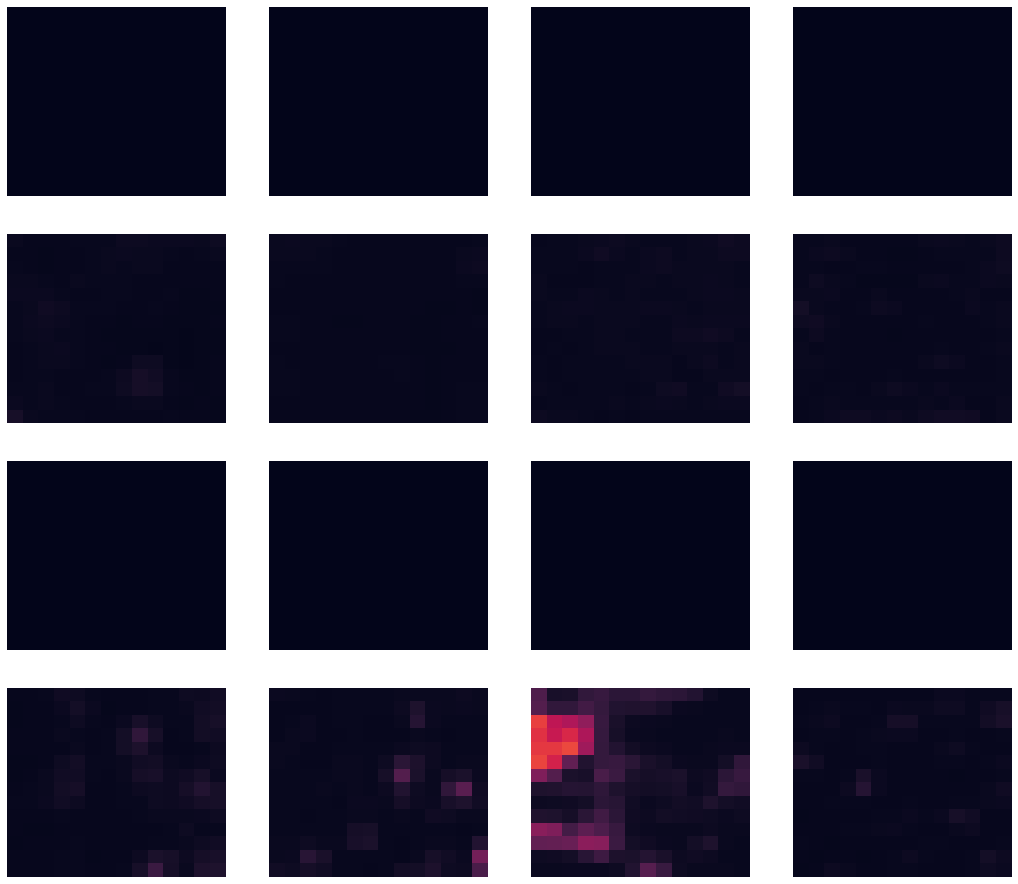

In [32]:
print(start/len(test_ids))
#test_ids = [x for x in range(test_x.shape[0])]
#test_ids = sorted(test_ids)
#test_ids = np.argwhere(abs(np.array(diffs)) > 25)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]

preds = []
trues = []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = test_x[idx].reshape(1, 13, 28, 28, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    print(i, test_data.iloc[i]['lat'], test_data.iloc[i]['long'])
    #print(i, (list(test_data.iloc[idx, 1])[0], list(test_data.iloc[idx, 2])[0]), diffs[i[0]])
    #y, mapshape = aggregate_maxes(test_y[idx], y)
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)

start = start + 8 

# 123, 334, 680, 875, 917, 950

In [33]:
train_ids = [x for x in range(len(train_y))]
diffs = np.zeros((len(train_ids), ))
for idx in tnrange(0, len(train_ids) - 16, 20):
    x_input = train_x[idx:idx + 20].reshape(20, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  #inp_median: median_input,
                                  length: np.full((20,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(20, 14, 14)
    y[y > 0.4] = 1.0
    y[y < 0.4] = 0.
    diff = np.sum(y, axis = (1, 2)) - np.sum(train_y[idx: idx + 20], axis = (1, 2))
    diffs[idx : idx + 20] = diff

data['diffs'] = diffs
data.to_csv("data_diffs.csv")

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [83]:
train_ids = [x for x in range(train_x.shape[0])]
start = 0

[208, 209, 210, 211, 212, 213, 214, 215]
208 141238363 13.280144489744147 -13.965938199999998
209 141238364 13.281073619744136 -13.81294345
210 141238365 13.266324639744408 -13.8039569
211 141238366 13.255626069744606 -13.827759699999998
212 141238367 13.25783101974455 -13.82979505
213 141238368 12.913657079750733 -14.05445974
214 141238369 13.07308384974786 -14.55135335
215 141238370 13.072679219747874 -14.523433430000004


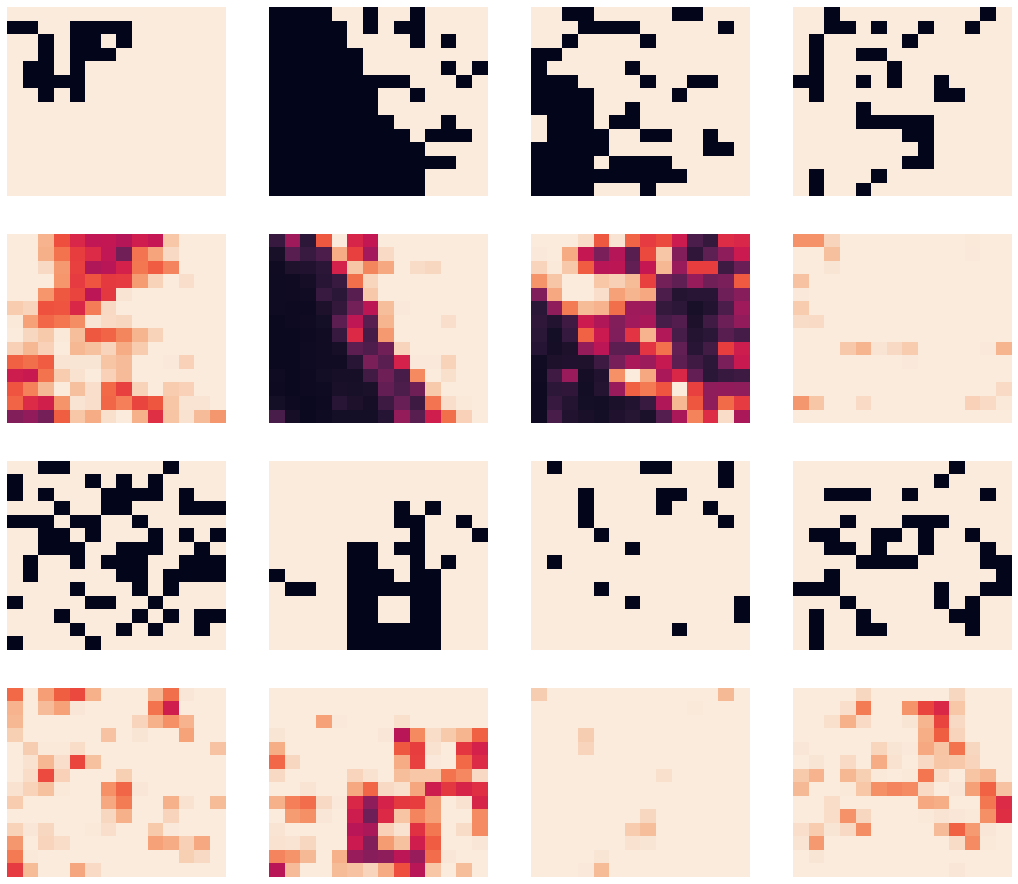

In [110]:
#train_ids = np.argwhere(np.logical_and(abs(np.array(diffs)) >= 70,
#                        abs(np.array(diffs)) < 200))

matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
             train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
preds = []
trues = []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = train_x[idx].reshape(1, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                    })
    y = np.array(y).reshape(14, 14)    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    
    #print(idx, (list(data.iloc[idx, 1])[0], list(data.iloc[idx, 2])[0]))
    print(idx, data.iloc[idx, 0], data.iloc[idx, 1],
          data.iloc[i, 2])
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

In [139]:
hkl.dump(train_x, f"../data/train/train_x.hkl", mode='w', compression='gzip')
hkl.dump(train_y, f"../data/train/train_y.hkl", mode='w', compression='gzip')
data.to_csv(f"../data/train/train_plot_ids.csv", index = False)

In [137]:
data = data.drop([8, 12, 33], axis = 0)


In [ ]:
141237871, 141237875
#[ ]